## Music Genre Classification using an Ensemble Technique-Extreme Gradient Boosting

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.ensemble as ske
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance
from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

#### Dataframe from extracted features from audio file

In [2]:
df = pd.read_csv('Data/features_3_sec.csv')


In [3]:
df.shape

(9990, 60)

In [4]:
df.label.value_counts().reset_index()

,index,label
0,reggae,1000
1,pop,1000
2,metal,1000
3,jazz,1000
4,blues,1000
5,disco,999
6,rock,998
7,classical,998
8,hiphop,998
9,country,997


In [5]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [6]:
# update labels in df 
df.label = [label_index[l] for l in df.label]

In [7]:
shuffle_data = df.sample(frac=1, random_state=seed).reset_index(drop=True)

### Remove unnecessary columns

In [8]:

shuffle_data.drop(['filename', 'length'], axis=1, inplace=True)
df_target = shuffle_data.pop('label')
df_X = shuffle_data

In [26]:
# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_target, train_size=0.7, random_state=seed, stratify=df_target)
X_val, X_test, y_val, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [27]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [28]:
def ProbabilityPrediction(clf, X, val=False):
    y_true = y_train
    if val:
        X = X_val[X.columns]
        y_true = y_val
    y_pred_proba_X = clf.predict_proba(X)
    y_pred_X = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6, 6))
    skm.plot_confusion_matrix(clf, X, y_true, cmap=plt.cm.Blues, ax=ax)
    plt.show()
    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print

In [29]:
def ProbabilityPrediction_test(clf, X, test=True):
    y_true = y_train
    if test:
        X = X_test[X.columns]
        y_true = y_test
    y_pred_proba_X = clf.predict_proba(X)
    y_pred_X = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6, 6))
    skm.plot_confusion_matrix(clf, X, y_true, cmap=plt.cm.Blues, ax=ax)
    plt.show()
    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print

## Model building

### Feature Selection

In [37]:
#XGBClassifier
xgbc = XGBClassifier(n_estimators=50, random_state=seed)
xgbc.fit(X_train, y_train)

[12:24:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=12, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
X_train.shape

(6993, 57)

### Testing prediction 

In [39]:
y_pred_proba_X = xgbc.predict_proba(X_train)
y_pred_X = xgbc.predict(X_train)

In [40]:
#predictProba(xgbc, X_train_xg, True)
y_pred_Xval = xgbc.predict(X_val)

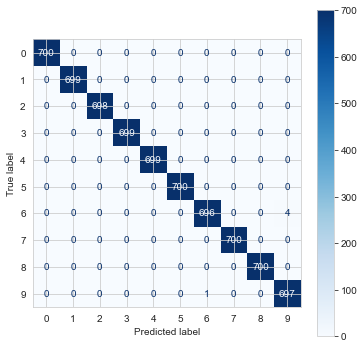

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.999     0.994     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.994     0.999     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [41]:
ProbabilityPrediction(xgbc, X_train)

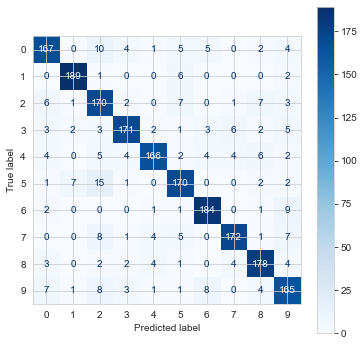

              precision    recall  f1-score   support

           0      0.865     0.843     0.854       198
           1      0.945     0.955     0.950       198
           2      0.766     0.863     0.811       197
           3      0.910     0.864     0.886       198
           4      0.927     0.843     0.883       197
           5      0.854     0.859     0.856       198
           6      0.902     0.929     0.915       198
           7      0.920     0.869     0.894       198
           8      0.877     0.899     0.888       198
           9      0.813     0.833     0.823       198

    accuracy                          0.876      1978
   macro avg      0.878     0.876     0.876      1978
weighted avg      0.878     0.876     0.876      1978



In [42]:
ProbabilityPrediction(xgbc, X_train , True)

## Selecting Best Features

In [43]:
# plot the permutation importances
imp_permutation = PermutationImportance(xgbc, random_state=seed).fit(X_train, y_train, n_iter=10)
indices_permutation = np.argsort(imp_permutation.feature_importances_)[::-1]
feat_permutation = [X_val.columns.tolist()[i] for i in indices_permutation]

In [44]:
imp_permutation = PermutationImportance(xgbc, random_state=seed).fit(X_train, y_train, n_iter=10)
print("Feature Importances using Permutation Importance")
eli5.show_weights(imp_permutation, feature_names = X_val.columns.tolist())

Feature Importances using Permutation Importance


Weight,Feature
0.1248 ± 0.0049,perceptr_var
0.0421 ± 0.0026,mfcc4_mean
0.0269 ± 0.0019,chroma_stft_mean
0.0225 ± 0.0030,harmony_mean
0.0154 ± 0.0021,perceptr_mean
0.0128 ± 0.0011,mfcc9_mean
0.0103 ± 0.0021,mfcc6_mean
0.0092 ± 0.0017,harmony_var
0.0082 ± 0.0015,spectral_bandwidth_mean
0.0053 ± 0.0012,rms_var


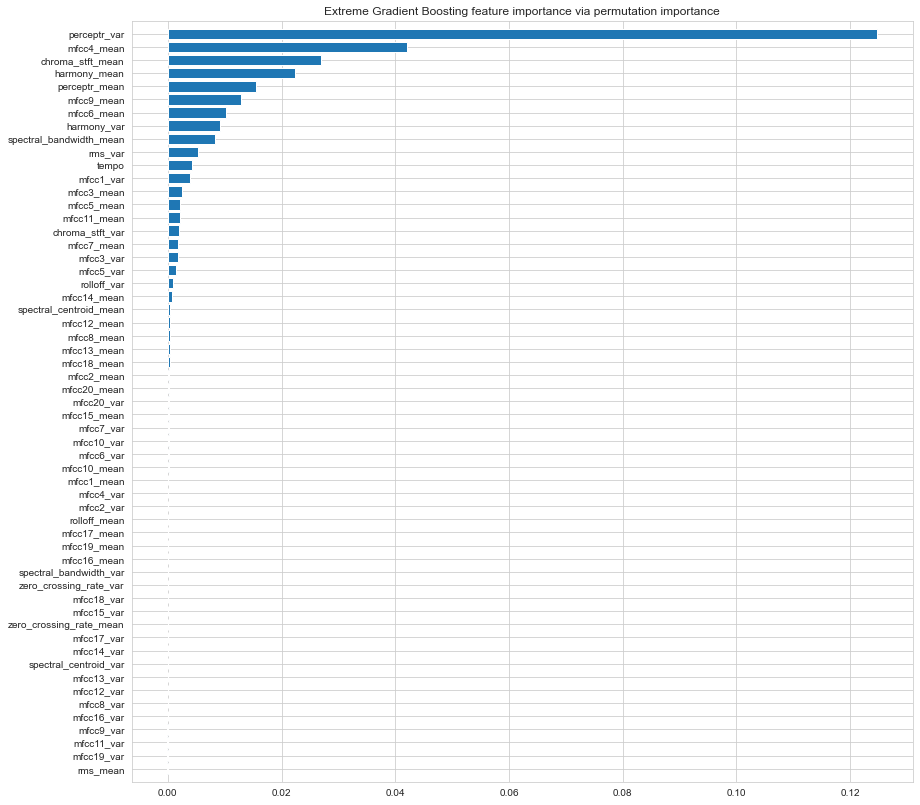

In [45]:
# plot the permutation importances
indices_permutation = np.argsort(imp_permutation.feature_importances_)[::-1]
feat_permutation = [X_val.columns.tolist()[i] for i in indices_permutation]
plt.figure(figsize=(14, 14))
plt.title("Extreme Gradient Boosting feature importance via permutation importance")
plt.barh(range(X_val.shape[1]), imp_permutation.feature_importances_[indices_permutation])
plt.yticks(range(X_val.shape[1]), feat_permutation)
plt.ylim([X_val.shape[1], -1])
plt.show()

### Ensemble model using top 30 features

In [46]:
#xgbc = XGBClassifier(n_estimators=50, random_state=seed)

X_train_perm = X_train[feat_permutation[:30]]
X_train_xg = X_train_perm
X_test_xg = X_test[feat_permutation[:30]]
xgbc.fit(X_train_xg,y_train)

[12:46:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=12, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

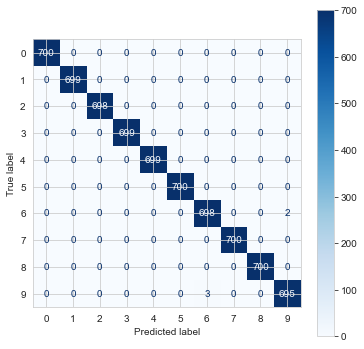

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [47]:
#Training Set
ProbabilityPrediction(xgbc, X_train_xg)
#predictProba(xgbc, X_train_perm, dev=True)

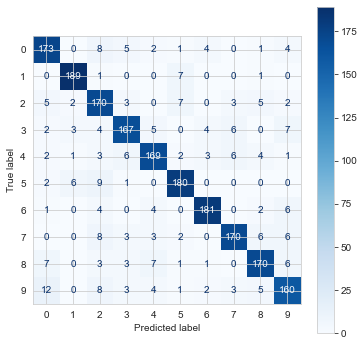

              precision    recall  f1-score   support

           0      0.848     0.874     0.861       198
           1      0.940     0.955     0.947       198
           2      0.780     0.863     0.819       197
           3      0.874     0.843     0.859       198
           4      0.871     0.858     0.864       197
           5      0.896     0.909     0.902       198
           6      0.928     0.914     0.921       198
           7      0.904     0.859     0.881       198
           8      0.876     0.859     0.867       198
           9      0.833     0.808     0.821       198

    accuracy                          0.874      1978
   macro avg      0.875     0.874     0.874      1978
weighted avg      0.875     0.874     0.874      1978



In [48]:
#Validation Set
ProbabilityPrediction(xgbc, X_train_xg, True)

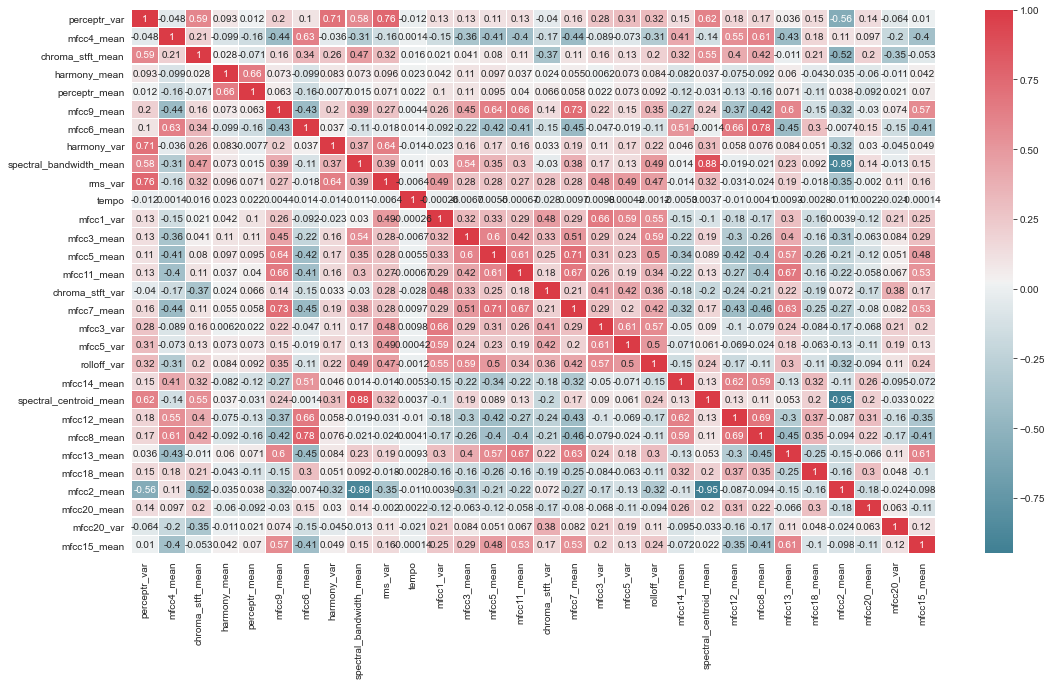

In [49]:
# plot correlation among top 30 selected featuers
plt.figure(figsize = (18, 10))
sns.heatmap(X_train_perm.corr(method='spearman'), annot = True, linewidths=.2, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

## XGB Model Hyperparameter Tuning

In [50]:
#xgb_model = XGBClassifier(n_estimators=10, random_state=seed)

xgb_params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

In [51]:
# Use the random grid to search for best hyperparameters
xgb_random = skms.RandomizedSearchCV(estimator = xgbc, param_distributions=xgb_params, n_iter=20, cv = 3, verbose=2, n_jobs = -1, random_state=seed, scoring='f1_weighted', return_train_score=True)
# Fit the random search model
xgb_random.fit(X_train_xg, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.2min finished


[12:59:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=50, n_jobs=4,
                                           num_par...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001957769DC70>,
   

### Performance metrics

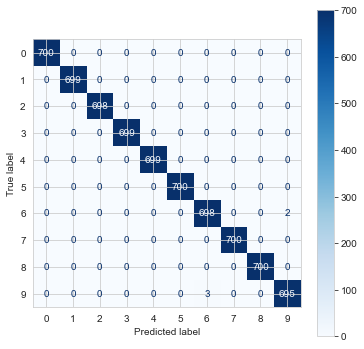

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [55]:
#Training set
ProbabilityPrediction(xgb_random.best_estimator_, X_train_xg)

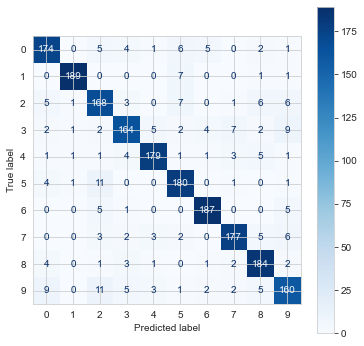

              precision    recall  f1-score   support

           0      0.874     0.879     0.877       198
           1      0.979     0.955     0.967       198
           2      0.812     0.853     0.832       197
           3      0.882     0.828     0.854       198
           4      0.932     0.909     0.920       197
           5      0.874     0.909     0.891       198
           6      0.935     0.944     0.940       198
           7      0.917     0.894     0.905       198
           8      0.876     0.929     0.902       198
           9      0.833     0.808     0.821       198

    accuracy                          0.891      1978
   macro avg      0.891     0.891     0.891      1978
weighted avg      0.891     0.891     0.891      1978



In [52]:
#Validation Set
ProbabilityPrediction(xgb_random.best_estimator_, X_train_xg, True)

In [53]:
#Testing Set
y_pred_X = xgb_random.best_estimator_.predict(X_test[X_train_xg.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("XGB Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.892     0.892     0.892       102
           1      0.914     0.950     0.932       101
           2      0.792     0.824     0.808       102
           3      0.868     0.902     0.885       102
           4      0.956     0.853     0.902       102
           5      0.837     0.853     0.845       102
           6      0.960     0.941     0.950       102
           7      0.931     0.922     0.926       102
           8      0.886     0.912     0.899       102
           9      0.818     0.794     0.806       102

    accuracy                          0.884      1019
   macro avg      0.885     0.884     0.884      1019
weighted avg      0.885     0.884     0.884      1019

XGB Test Accuracy - 88.42001962708538
